In [ ]:
%load_ext autoreload
%autoreload 2

import logging
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch import tensor

import weight_formats.experiments as E

logging.basicConfig(level=logging.WARNING, force=True)
matplotlib.rcParams.update({
    "axes.spines.top": False, "axes.spines.right": False, "legend.frameon": False,
    "figure.figsize": (5, 3),
})

2025-06-30:10:34:31,010 INFO     [rouge_scorer.py:83] Using default tokenizer.
2025-06-30:10:34:31,793 INFO     [_client.py:1025] HTTP Request: GET https://raw.githubusercontent.com/BerriAI/litellm/main/model_prices_and_context_window.json "HTTP/1.1 200 OK"


In [3]:
runs = E.runs("20250625-qat-initial-sweep")
len(runs)

25

## Debug final validation

In [3]:
# Initial debug run - multiple final validations
run, = (run for run in runs if run.config.get("tag") == "debug-validation")
s = run.summary
print("log", s.train.valid_kl_div[-1])
print("debug_valid", s.debug_valid.valid_kl_div)
print("debug_valid_eager", s.debug_valid_eager.valid_kl_div)
print("debug_valid_eager_unsharded", s.debug_valid_eager_unsharded.valid_kl_div)
print("final", s.valid_kl_div)

log 0.060712218
debug_valid 0.060712218
debug_valid_eager 0.066282697
debug_valid_eager_unsharded 0.066282697
final 0.10742062


In [29]:
# With embedding sharing fix
for run in runs:
    if run.config.get("tag") == "test-weight-sharing-fix" and run.meta.status != "running":
        print(f"Compile={run.config.exe.compile} Code={run.config.code_changes}")
        s = run.summary
        print("  log", s.train.valid_kl_div[-1])
        print("  debug_valid", s.debug_valid.valid_kl_div)
        print("  debug_valid_eager", s.debug_valid_eager.valid_kl_div)
        if "debug_valid_eager_unsharded" in s:
            print("  debug_valid_eager_unsharded", s.debug_valid_eager_unsharded.valid_kl_div)
        if "valid_kl_div" in s:
            print("  final", s.valid_kl_div)
        t_total = run.meta.duration
        t_steps = tensor(run.summary.train.duration[1:]).mean().item() * run.config.train.steps
        t_downstream = sum(r._duration for r in run.summary.downstream.values()) if "downstream" in run.summary else 0
        print(f"  time (Total / Training / Downstream / Other): {t_total/60**2:.1f} / {t_steps/60**2:.1f} / {t_downstream/60**2:.1f} / {(t_total - t_downstream - t_steps)/60**2:.1f} hr")
        print()

Compile=None Code={'fix_fsdp_embedding_sharing': True}
  log 0.061769731
  debug_valid 0.061769731
  debug_valid_eager 0.061769731
  debug_valid_eager_unsharded 0.061769731
  final 0.061769731
  time (Total / Training / Downstream / Other): 5.9 / 3.7 / 0.7 / 1.5 hr

Compile=default Code={'fix_fsdp_embedding_sharing': True}
  log 0.062044226
  debug_valid 0.062044226
  debug_valid_eager 0.066583782
  time (Total / Training / Downstream / Other): 4.1 / 2.9 / 0.0 / 1.1 hr

Compile=default Code={'compile_disable': ['Weight.forward'], 'fix_fsdp_embedding_sharing': True}
  log 0.061428685
  debug_valid 0.061428685
  debug_valid_eager 0.06145554
  debug_valid_eager_unsharded 0.06145554
  final 0.06145554
  time (Total / Training / Downstream / Other): 5.6 / 3.5 / 0.7 / 1.5 hr



In [5]:
dfd = pd.DataFrame.from_records([
    dict(
        # Config
        test="baseline" if run.config.test == {} else "4b",
        compile=run.config.exe.compile,
        # Outcome
        **{k: v.primary_score for k, v in run.summary.downstream.items()}
    )
    for run in runs
    if run.meta.status == "finished"
    and (run.config.get("tag") == "test-weight-sharing-fix" or run.config.test == {})
])
display(dfd)

,test,compile,socialiqa:mc,hellaswag,openbookqa:mc,arc_challenge:mc,arc_easy:mc,csqa:mc,piqa,winogrande,boolq
0,baseline,default,0.463664,0.657,0.432,0.324415,0.563158,0.419328,0.748640,0.598264,0.639755
1,4b,None,0.423234,0.640,0.382,0.280936,0.419298,0.305487,0.741567,0.595896,0.607951
2,4b,default,0.410440,0.639,0.372,0.274247,0.403509,0.325962,0.742655,0.587214,0.619878


## Downstream tasks (note: broken embedding sharing)

In [31]:
baselines, = [r.summary.downstream for r in runs if r.config.test == {}]
pd.DataFrame.from_records([dict(task=k, score=v.primary_score, duration=v._duration) for k, v in baselines.items()])

,task,score,duration
0,socialiqa:mc,0.463664,67.764462
1,hellaswag,0.657000,265.611520
2,openbookqa:mc,0.432000,20.760011
3,arc_challenge:mc,0.324415,15.123065
4,arc_easy:mc,0.563158,21.499312
5,csqa:mc,0.419328,43.798853
6,piqa,0.748640,234.978120
7,winogrande,0.598264,84.531562
8,boolq,0.639755,112.079290


In [27]:
dfd = pd.DataFrame.from_records([
    dict(
        # Config
        tag=run.config.get("tag", None),
        steps=run.config.train.steps,
        batch_size=run.config.train.batch_size,
        lr=run.config.opt.lr,
        # ebits=run.config.test.fmt.element_bits if "fmt" in run.config.test else None,
        compile_fix="Weight.forward" in run.config.get("code_changes", {}).get("compile_disable", []),
        # Outcome
        **{k: v.primary_score for k, v in run.summary.downstream.items()}
    )
    for run in runs
    if run.meta.status == "finished"
])
display(dfd
        .pipe(lambda d: d[(dfd.steps == 0) | (dfd.tag.isin(["longer-runs", "test-weight-sharing-fix"]))])
        .pipe(lambda d: d.assign(log2lr=np.log2(d.lr)).drop(columns="lr"))
        .set_index(["tag", "steps", "batch_size", "log2lr", "compile_fix"])
        .pipe(lambda d: d[sorted(d.columns)])
        .pipe(lambda d: d.assign(mean=d.mean(axis=1)))
        .sort_values("mean", ascending=False).style.background_gradient())

/home/ubuntu/work/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Load results

In [3]:
# 0) Baselines (no training)
# 1) 3-bit short runs (2**14 examples, 30 mins)
# 2) 4-bit long runs (2**17 examples, 3 hours)
# 3) "rerun-no-compile-weight" re-run with no compile Weight.forward()

df = pd.DataFrame.from_records([
    dict(
        # Config
        steps=run.config.train.steps,
        lr=run.config.opt.lr,
        batch_size=run.config.train.batch_size,
        log_interval=run.config.train.log_interval,
        ebits=run.config.test.fmt.element_bits,
        compile_fix="Weight.forward" in run.config.get("code_changes", {}).get("compile_disable", []),
        tag=run.config.get("tag"),
        # Outcome
        valid_kl=run.summary.valid_kl_div,
        log_loss=run.summary.train.loss[1:],
        log_valid_kl_div=run.summary.train.valid_kl_div[1:],
        log_duration=run.summary.train.duration[1:],
        step_time=run.summary.train.duration[-1],
        duration=run.meta.duration,
    )
    for run in runs
    if run.config.train.steps
    and run.meta.status == "finished"
])
df["examples"] = df.steps * df.batch_size
df["final_log_valid_kl"] = df.apply(lambda s: s.log_valid_kl_div[-1], axis=1)
display(df.head())

,steps,lr,batch_size,log_interval,ebits,compile_fix,tag,valid_kl,log_loss,log_valid_kl_div,log_duration,step_time,duration,examples,final_log_valid_kl
0,1024.0,3.814697e-06,16.0,64.0,3.0,False,None,0.460257,"[0.95783335, 0.5953747, 0.56082594, 0.5093264,...","[0.61528242, 0.54298931, 0.51076627, 0.4902534...","[2.0054896, 1.1657278, 1.1602382, 1.1593542, 1...",1.156296,1597.49430,16384.0,0.422092
1,256.0,3.814697e-06,64.0,64.0,3.0,False,None,0.516646,"[0.90747839, 0.55461401, 0.51908058, 0.50765979]","[0.58140111, 0.51166159, 0.49068433, 0.48597306]","[3.2931255, 2.9489367, 2.9575505, 2.9399706]",2.939971,949.34356,16384.0,0.485973
2,1024.0,1.525879e-05,16.0,64.0,3.0,False,None,0.402028,"[0.7205084, 0.52387512, 0.50998509, 0.46243259...","[0.530357, 0.48587054, 0.46087104, 0.45153821,...","[1.6351225, 1.1649687, 1.1607094, 1.1584937, 1...",1.154503,1543.37110,16384.0,0.357762
3,256.0,1.525879e-05,64.0,64.0,3.0,False,None,0.426284,"[0.66850662, 0.45983344, 0.42800328, 0.41339782]","[0.47904429, 0.4246999, 0.4012233, 0.39586961]","[3.2889903, 2.9464146, 2.9574333, 2.9378654]",2.937865,948.91068,16384.0,0.395870
4,1024.0,9.536743e-07,16.0,64.0,3.0,False,None,0.553443,"[1.465435, 0.81518286, 0.71719331, 0.64024252,...","[0.8789916, 0.69587922, 0.63906384, 0.60509425...","[1.6353486, 1.16835, 1.1638902, 1.1634578, 1.1...",1.158753,1546.35910,16384.0,0.525382


## Short runs, 3-bit

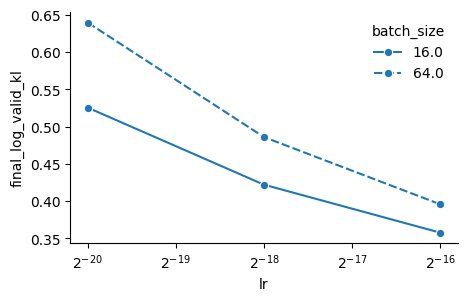

In [15]:
ax = sns.lineplot(data=df[df.examples == 2**14], y="final_log_valid_kl", x="lr", style="batch_size", marker="o")
ax.set_xscale("log", base=2)

Text(0.5, 0, 'Steps')

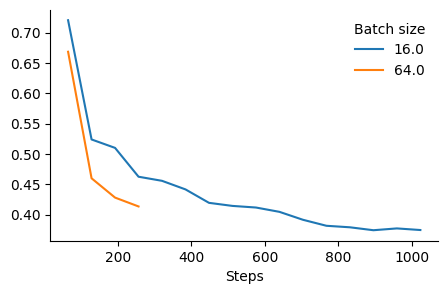

In [17]:
_, ax = plt.subplots()
for batch_size, s in df[df.examples == 2**14].groupby("batch_size").apply(lambda g: g.loc[g.valid_kl.idxmin()], include_groups=False).iterrows():
    ax.plot(s.log_interval * torch.arange(1, 1+len(s.log_loss)), s.log_loss, label=f"{batch_size}")
ax.legend(title="Batch size")
ax.set_xlabel("Steps")

## Long runs 4-bit

,batch_size,steps,lr,compile_fix,final_log_valid_kl,valid_kl
15,16.0,8192.0,0.000004,False,0.060712,0.107421
9,16.0,8192.0,0.000004,False,0.060799,0.105960
16,16.0,8192.0,0.000004,False,0.061770,0.061770
11,16.0,8192.0,0.000004,True,0.060817,0.103093
10,16.0,8192.0,0.000015,False,0.073643,0.516472
12,16.0,8192.0,0.000015,True,0.074412,0.516904
6,64.0,2048.0,0.000004,False,0.066647,0.079324
13,64.0,2048.0,0.000004,True,0.066832,0.075514
7,64.0,2048.0,0.000015,False,0.062445,0.097653
14,64.0,2048.0,0.000015,True,0.062051,0.091569


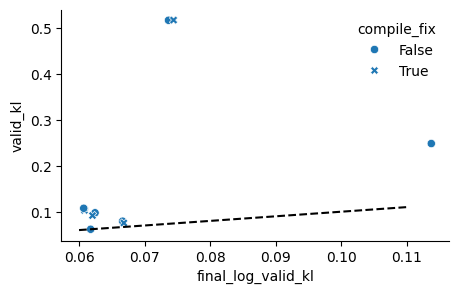

In [51]:
ax = sns.scatterplot(data=df[df.ebits == 4], y="valid_kl", x="final_log_valid_kl", style="compile_fix")
ax.plot([0.06, 0.11], [0.06, 0.11], "k--")
keys = ["batch_size", "steps", "lr", "compile_fix", "final_log_valid_kl", "valid_kl"]
display(df[df.ebits == 4][keys].sort_values(keys))

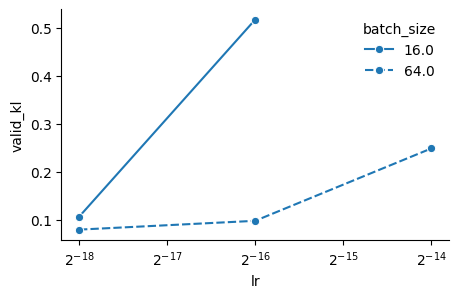

In [73]:
ax = sns.lineplot(data=df[df.examples == 2**17], y="valid_kl", x="lr", style="batch_size", marker="o")
ax.set_xscale("log", base=2)

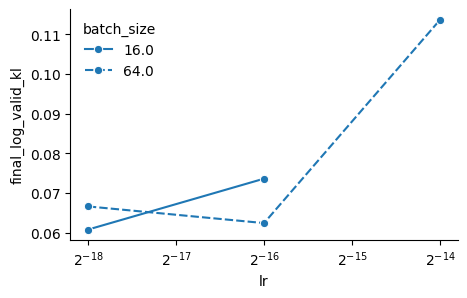

In [75]:
ax = sns.lineplot(data=df[df.examples == 2**17], y="final_log_valid_kl", x="lr", style="batch_size", marker="o")
ax.set_xscale("log", base=2)

final 0.061769731 last 0.061769731
final 0.075513676 last 0.066831507


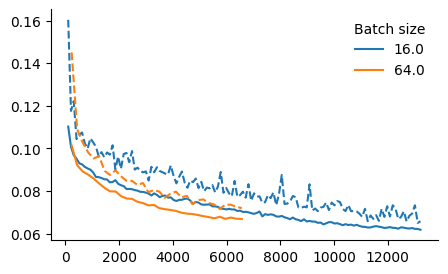

In [ ]:
_, ax = plt.subplots()
for (batch_size, s), color in zip(df[df.examples == 2**17].groupby("batch_size").apply(lambda g: g.loc[g.valid_kl.idxmin()], include_groups=False).iterrows(), sns.color_palette()):
    xs = s.log_interval * batch_size * torch.arange(1, 1+len(s.log_loss))
    xs = torch.cumsum(tensor(s.log_duration) * s.log_interval, 0)
    ax.plot(xs, s.log_loss, color=color, ls="--")
    ax.plot(xs, s.log_valid_kl_div, label=f"{batch_size}", color=color)
    print("final", s.valid_kl, "last", s.log_valid_kl_div[-1])
ax.legend(title="Batch size");

In [4]:
df.assign(final_log_valid_kl_div=df.apply(lambda s: s.log_valid_kl_div[-1], axis=1))[["tag", "ebits", "batch_size", "steps", "valid_kl", "final_log_valid_kl_div"]]

,tag,ebits,batch_size,steps,valid_kl,final_log_valid_kl_div
0,None,3.0,16.0,1024.0,0.460257,0.422092
1,None,3.0,64.0,256.0,0.516646,0.485973
2,None,3.0,16.0,1024.0,0.402028,0.357762
3,None,3.0,64.0,256.0,0.426284,0.395870
4,None,3.0,16.0,1024.0,0.553443,0.525382
5,None,3.0,64.0,256.0,0.655971,0.639468
6,None,4.0,64.0,2048.0,0.079324,0.066647
7,None,4.0,64.0,2048.0,0.097653,0.062445
8,None,4.0,64.0,2048.0,0.248285,0.113712
9,None,4.0,16.0,8192.0,0.105960,0.060799
